In [1]:
import numpy as np
import matplotlib.pyplot as plt

The meaning of some of the variables
```
lmbda -> arrival rate
mu -> service rate
IAT -> inter-arrival time
AT -> arrival time
ST -> service time
DT -> departure time
TT -> total time
WT -> waiting time
E_N -> the average number of customers in the system
E_Nq -> the average number of customers in the buffer
E_T -> the average total time a customer spent in the system
E_W -> average waiting time of a customer in the buffer
```



In [2]:
def main_loop(num_customers, AT, ST):
  DT = np.zeros(num_customers)
  #first customer
  DT[0] = AT[0] + ST[0]

  for i in range(1, num_customers):
    if AT[i] > DT[i - 1]:
      DT[i] = AT[i] + ST[i]
    else:
      DT[i] = DT[i - 1] + ST[i]

  TT = DT - AT
  WT = TT - ST
  return DT, TT, WT

In [3]:
def track_customers(AT, DT, max_N = 50, return_PMF=True):
  N = 0 #number of customers
  i, j = 0, 0 # i points to an arrival event and j to a depratrure event
  area_N, area_Nq = 0, 0 #area under curver of the N and Nq(number of customers in buffer)
  PMF = np.zeros(max_N)
  clock, prev_event_time = [0, 0] # clock points to the time of the current event
  last_arrival = max(AT)
  while( clock < last_arrival):
    clock = min(AT[i], DT[j])
    time_interval = clock - prev_event_time

    if clock == AT[i]: # arrival occurs before departure
      area_N += time_interval * N
      area_Nq += time_interval * max(N-1, 0)
      PMF[min(N, max_N - 1)] += time_interval
      prev_event_time = clock
      N += 1
      i += 1

    else: # departure occurs before arrival
      area_N += time_interval * N
      area_Nq += time_interval * max(N-1, 0)
      PMF[min(N, max_N - 1)] += time_interval
      prev_event_time = clock
      N -= 1
      j += 1

  #process the left departure events
  for j in range(j, len(DT)):
    clock = DT[j]
    time_interval = clock - prev_event_time
    area_N += time_interval * N
    area_Nq += time_interval * max(N-1, 0)
    PMF[min(N, max_N - 1)] += time_interval
    prev_event_time = clock
    N -= 1

  E_N = area_N / clock
  E_Nq = area_Nq / clock
  PMF = PMF / clock
  if return_PMF:
    return E_N, E_Nq, PMF
  return E_N, E_Nq

In [4]:
def simulation_results(lmbda, mu, num_customers = 100000, max_N=50, return_PMF=True):
  IAT = np.random.exponential(1/lmbda, num_customers)
  ST = np.random.exponential(1/mu, num_customers)
  AT = np.cumsum(IAT)
  DT, TT, WT = main_loop(num_customers, AT, ST)
  E_T, E_W = np.mean(TT), np.mean(WT)
  if return_PMF:
    E_N, E_Nq, PMF = track_customers(AT, DT, max_N, return_PMF)
    return E_N, E_Nq, E_T, E_W, PMF
  else:
    E_N, E_Nq = track_customers(AT, DT, max_N, return_PMF)
    return E_N, E_Nq, E_T, E_W

In [5]:
def theoretical_results(lmbda, mu):
  rho = lmbda / mu
  E_N = rho / (1 - rho)
  E_Nq = rho**2 / (1 - rho)
  E_T = 1 / (mu - lmbda)
  E_W = E_T - 1/mu
  return E_N, E_Nq, E_T, E_W

def theoretical_PMF(rho, max_N):
  i = np.arange(0, max_N, 1)
  output = (1 - rho) * rho**i
  return output

def theo_TT_PDF(t, lmbda, mu):
  return (mu - lmbda) * np.exp( -(mu - lmbda) * t)

In [13]:
def plot_pdf(input, lmbda, mu, num_bins = 50):
  #----specifiy the bins-------
  min_val, max_val = min(input), max(input)
  bin_width = (max_val - min_val) / num_bins
  bins_center = np.linspace(min_val + bin_width/2, max_val - bin_width/2, num_bins)
  freq, bins_edges = np.histogram(input, bins=num_bins)

  #-----compute EPDF and theoretical PDF-----
  EPDF = freq / sum(freq) / bin_width
  theo_PDF = theo_TT_PDF(bins_center, lmbda, mu)

  #------plot------
  figure = plt.figure(figsize=(10, 4), tight_layout=True, dpi=100)
  ax1 = figure.add_subplot(121)
  ax1.bar(bins_center, EPDF, width=bin_width,
          edgecolor="black", color=(0.16, 0.33, 0.8, 1), label="Simulation")
  ax1.plot(bins_center, theo_PDF, "--o", color=((1, 0.1, 0.1, 1)),
           markerfacecolor="None", linewidth=2.0, label="Theoretical")
  ax1.set_xlabel("Time", fontweight=500)
  ax1.set_ylabel("Prob[T = t]", fontweight=500)
  ax1.tick_params(labelsize=8)
  plt.grid(alpha=0.3, color="black", linewidth=0.5)
  plt.legend()

  ax2 = figure.add_subplot(122)
  ax2.semilogy(bins_center, EPDF, color="red", linestyle="None", marker="o",
               markerfacecolor="None", label="Simulation")
  ax2.semilogy(bins_center, theo_PDF, color="blue", label="Theoretical")
  ax2.set_xlabel("Time")
  ax2.set_ylabel("Prob[T = t]")
  ax2.tick_params(labelsize=8)

  plt.grid(alpha=0.3, color="black", linewidth=0.5)
  plt.legend()

In [14]:
def plot_PMF(EPMF, rho, max_N):
  n_customer = np.arange(0, max_N, 1)
  theo_PMF = theoretical_PMF(rho, max_N)

  figure = plt.figure(figsize=(10, 4), tight_layout=True, dpi=100)
  ax1 = figure.add_subplot(121)
  ax1.bar(n_customer, EPMF, width=1,
          edgecolor="black", color=(0.16, 0.33, 0.8, 1), label="Simulation")
  ax1.plot(n_customer, theo_PMF, "--o", color=((1, 0.1, 0.1, 1)),
           markerfacecolor="None", linewidth=2.0, label="Theoretical")
  ax1.set_xlabel("n customer", fontweight=500)
  ax1.set_ylabel("PMF", fontweight=500)
  ax1.tick_params(labelsize=8)
  plt.grid(alpha=0.3, color="black", linewidth=0.5)
  plt.legend()

  ax2 = figure.add_subplot(122)
  ax2.semilogy(n_customer, EPMF, color="red", linestyle="None", marker="o",
               markerfacecolor="None", label="Simulation")
  ax2.semilogy(n_customer, theo_PMF, color="blue", label="Theoretical")
  ax2.set_xlabel("n customer")
  ax2.set_ylabel("PMF")
  ax2.tick_params(labelsize=8)

  plt.grid(alpha=0.3, color="black", linewidth=0.5)
  plt.legend()

-----Theoretical resutls-----
E[N] = 9.000000000000002
E[Nq] = 8.100000000000003
E[T] = 1.0
E[W] = 0.9

-----Simulation resutls-----
E[N] = 8.900394598054906
E[Nq] = 8.001659579412447
E[T] = 0.9888063302272756
E[W] = 0.8889596474942799


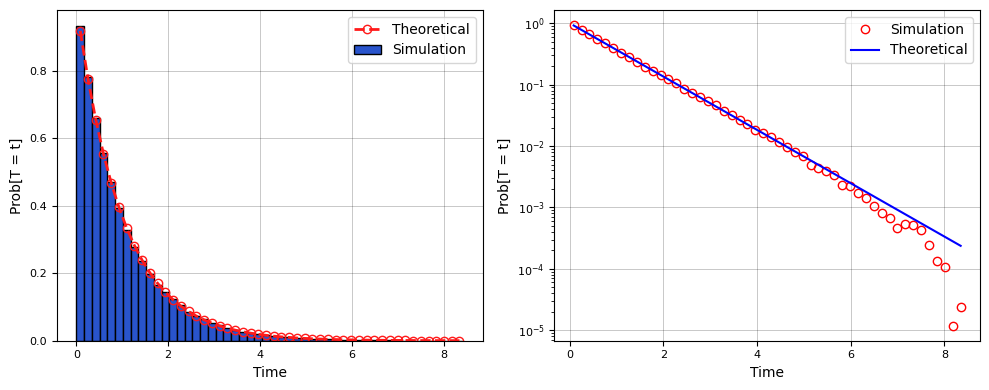

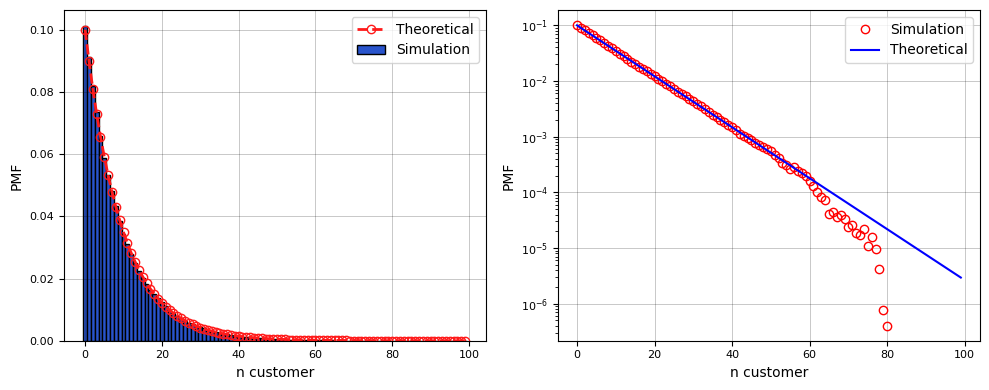

In [15]:
#------info to generate results----
lmbda = 9
mu = 10
rho = lmbda / mu
num_customers = 1000000

#-----theoretical results-----
theo_E_N, theo_E_Nq, \
theo_E_T, theo_E_W = theoretical_results(lmbda, mu)
print("-----Theoretical resutls-----")
print(f"E[N] = {theo_E_N}")
print(f"E[Nq] = {theo_E_Nq}")
print(f"E[T] = {theo_E_T}")
print(f"E[W] = {theo_E_W}")

#-----Simulation results----
IAT = np.random.exponential(1/lmbda, num_customers)
AT = np.cumsum(IAT)
ST = np.random.exponential(1/mu, num_customers)

#simulate
DT, TT, WT = main_loop(num_customers, AT, ST)
max_N = 100
sim_E_N, sim_E_Nq, sim_PMF = track_customers(AT, DT, max_N)
sim_E_T = np.mean(TT)
sim_E_W = np.mean(WT)

print("\n-----Simulation resutls-----")
print(f"E[N] = {sim_E_N}")
print(f"E[Nq] = {sim_E_Nq}")
print(f"E[T] = {sim_E_T}")
print(f"E[W] = {sim_E_W}")

#---plot results----
plot_pdf(TT, lmbda, mu, num_bins=50)
plot_PMF(sim_PMF, rho, max_N)

In [ ]:
def variable_traffic_intensity(num_customers=100000, start = 0.05,
                               stop = 0.95, step_size=0.05):
  rho = np.arange(start, stop + step_size, step_size)
  mu = 10

  #------labels------
  labels = ["E[N]", "E[Nq]", "E[T]", "E[W]"]
  #-------Dictionary to store simulation results--------
  sim_results = {
      "E[N]": np.zeros(len(rho)),
      "E[Nq]": np.zeros(len(rho)),
      "E[T]": np.zeros(len(rho)),
      "E[W]": np.zeros(len(rho)),
  }
  #-------Dictionary to store theoretical results--------
  theo_results = {
      "E[N]": np.zeros(len(rho)),
      "E[Nq]": np.zeros(len(rho)),
      "E[T]": np.zeros(len(rho)),
      "E[W]": np.zeros(len(rho)),
  }


  #------simulation-------
  for i in range(len(rho)):
    lmbda = rho[i] * mu
    sim_output = simulation_results(lmbda, mu, num_customers, return_PMF=False)
    theo_output = theoretical_results(lmbda, mu)
    for j, label in enumerate(labels):
      sim_results[label][i] = sim_output[j]
      theo_results[label][i] = theo_output[j]

  #-------plotting---------
  labels = ["E[N]", "E[Nq]", "E[T]", "E[W]"]
  n_rows, n_cols = 2, 2
  figure = plt.figure(figsize=(10, 8), tight_layout=True, dpi=100)
  for i, label in enumerate(labels):
    ax = figure.add_subplot(n_rows, n_cols, i+1)
    ax.plot(rho, theo_results[label], "-", color="blue", label="theoretical")
    ax.plot(rho, sim_results[label], color="red", linestyle="None",
            marker="o", markerfacecolor="None", label="simulation")
    ax.set_xlabel("Traffic intensity")
    ax.set_ylabel(label)
    plt.grid(alpha=0.3, color="black", linewidth=0.5)
    plt.legend()

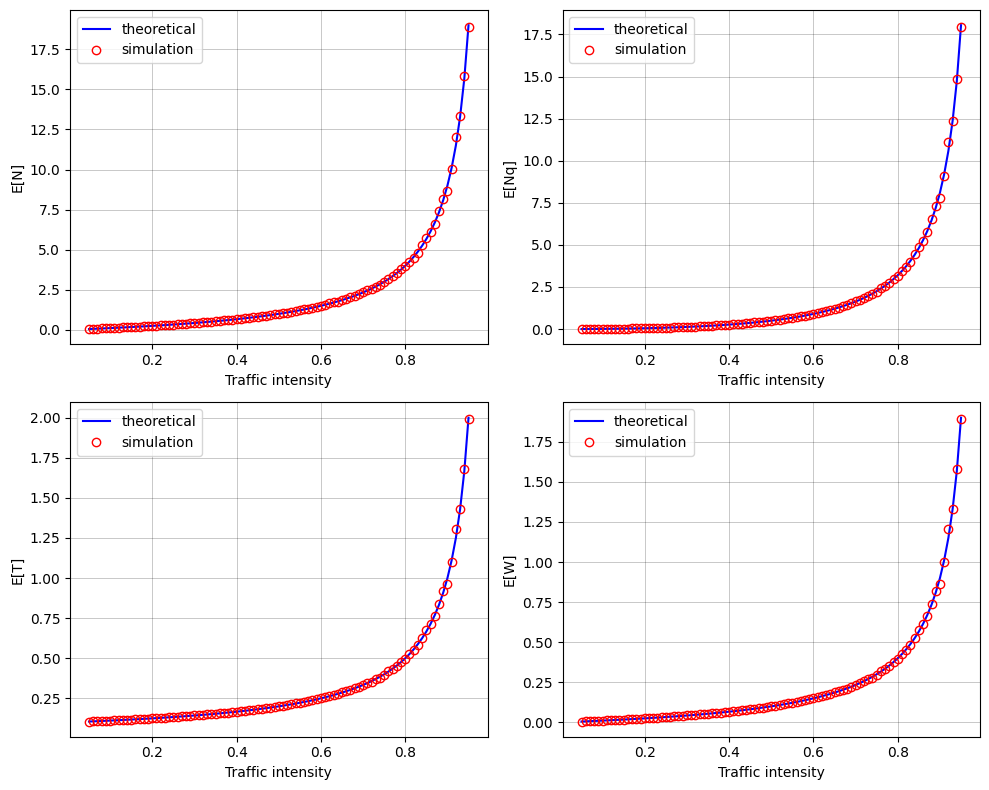

In [ ]:
variable_traffic_intensity(num_customers=10**6, step_size=0.01)